# SMMALA sampling of MLP weights using XOR data

Learn the XOR function by sampling the weights of a multi-layer perceptron (MLP) via SMMALA.

In [1]:
## Import packages

import numpy as np

import torch

from torch.utils.data import DataLoader
from torch.distributions import Normal

from eeyore.data import Iris
from eeyore.stats import softabs
from eeyore.models import mlp
from eeyore.mcmc import SMMALA

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Load XOR data

iris = Iris()
dataloader = DataLoader(iris, batch_size=150)

In [3]:
## Setup MLP model

hparams = mlp.Hyperparameters(dims=[4, 2, 3])
model = mlp.MLP(hparams=hparams)
model.prior = Normal(
    torch.zeros(model.num_params(), dtype=model.dtype),
    np.sqrt(3)*torch.ones(model.num_params(), dtype=model.dtype)
)

In [4]:
## Setup SMMALA sampler

theta0 = model.prior.sample()
sampler = SMMALA(model, theta0, dataloader, step=0.02, transform=lambda hessian: softabs(hessian, a=1000.))

In [5]:
## Run SMMALA sampler

sampler.run(num_iterations=11000, num_burnin=1000)

In [6]:
## Compute acceptance rate

sampler.chain.acceptance_rate()

0.788100004196167

In [7]:
## Compute Monte Carlo mean

sampler.chain.mean()

tensor([ 0.6094,  1.6845, -2.9925, -1.4240, -1.8798, -2.1147,  3.2195,  3.4221,
         0.1892, -3.0573,  5.8058, -2.7130, -5.5847, -4.6170, -1.9742,  5.9404,
        -2.3272,  1.9639, -2.9869], dtype=torch.float64)

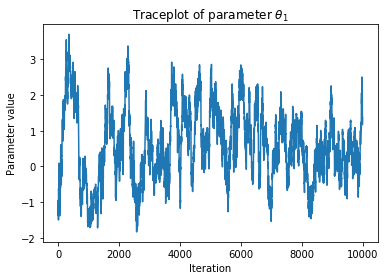

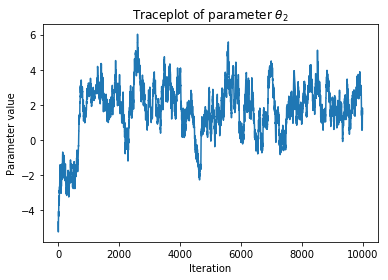

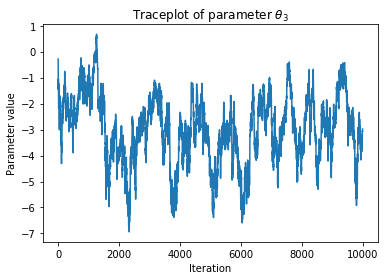

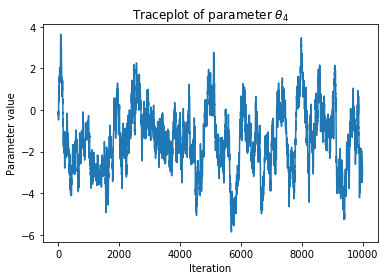

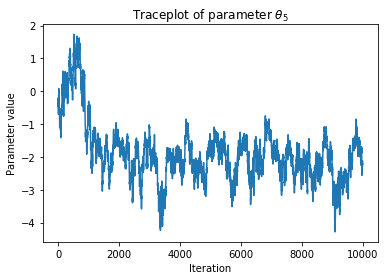

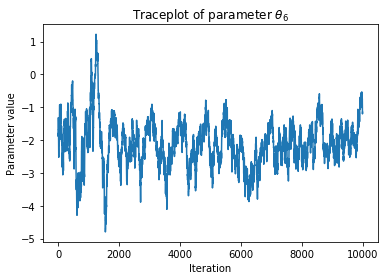

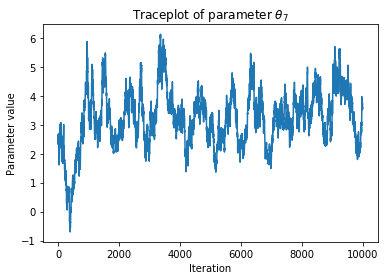

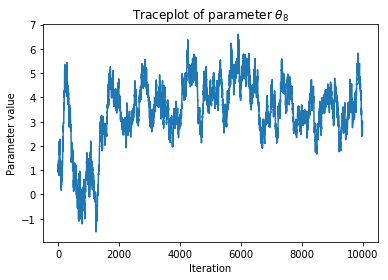

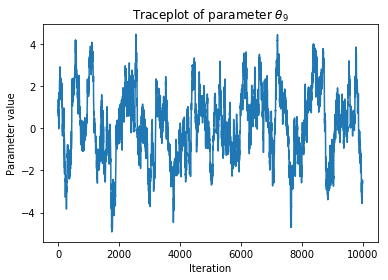

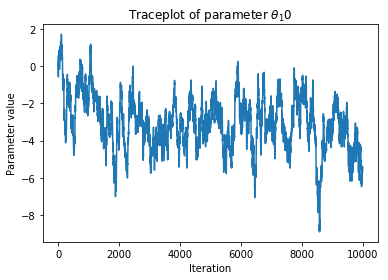

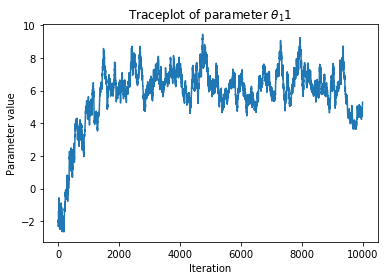

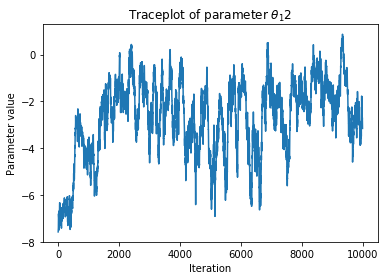

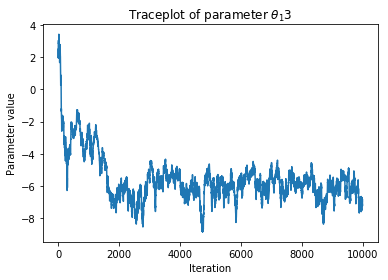

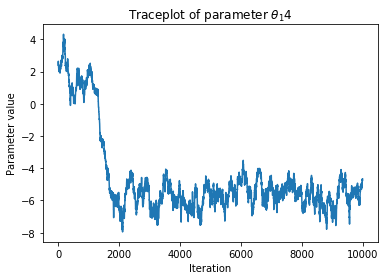

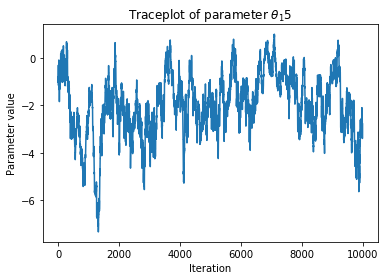

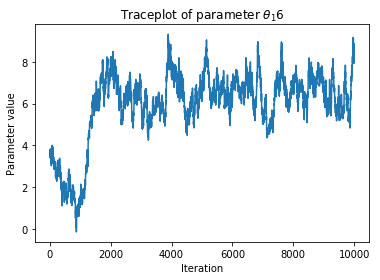

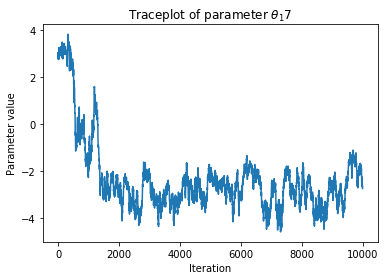

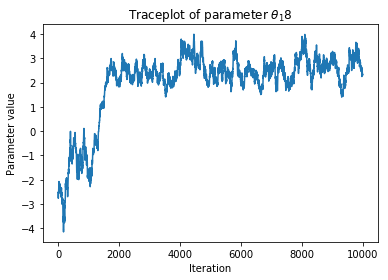

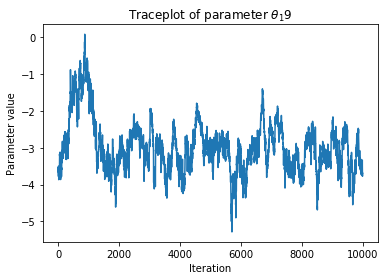

In [8]:
## Plot traces of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    plt.figure()
    sns.lineplot(range(len(chain)), chain)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Traceplot of parameter $\theta_{}$'.format(i+1))

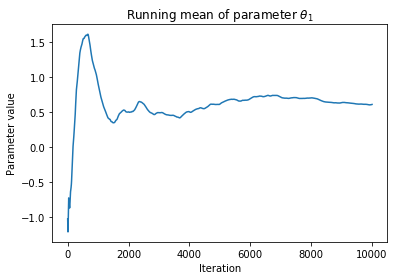

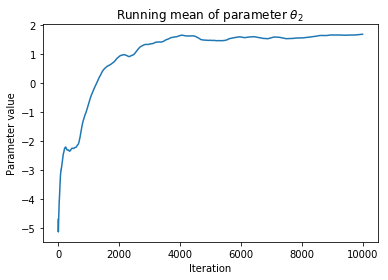

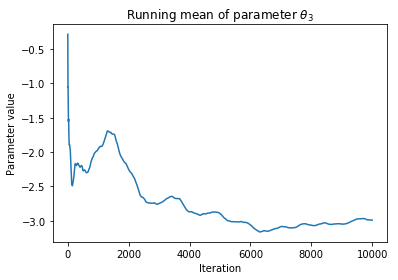

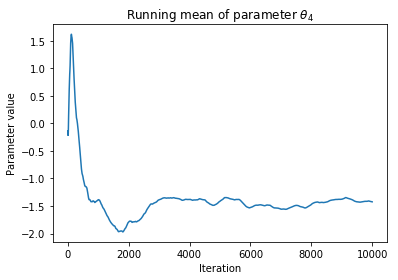

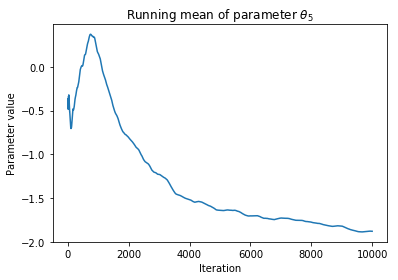

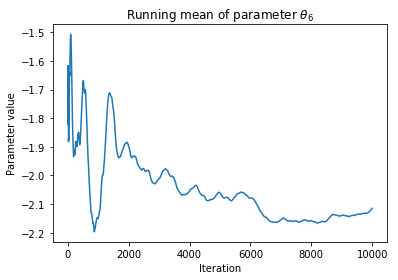

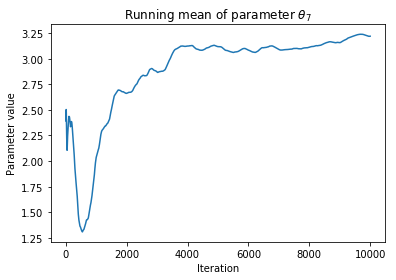

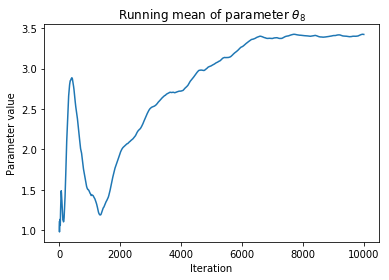

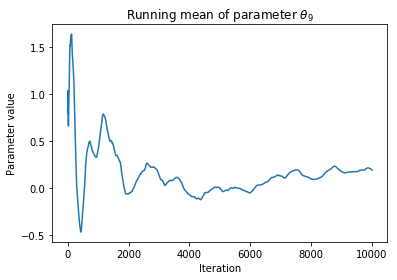

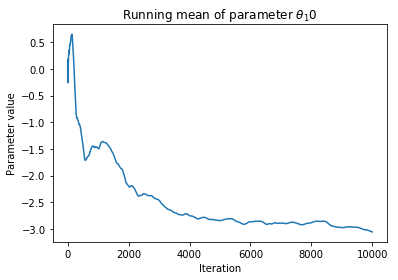

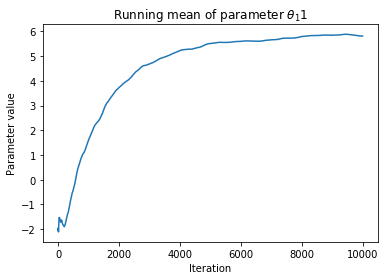

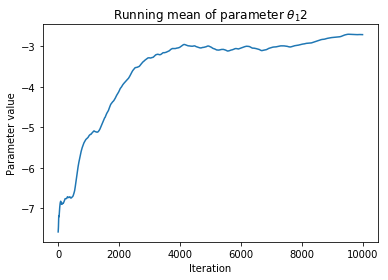

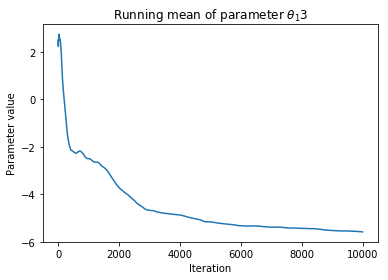

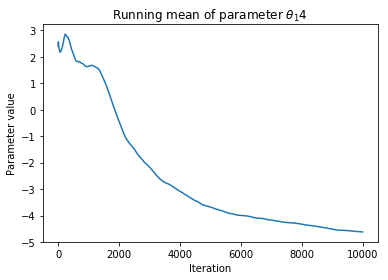

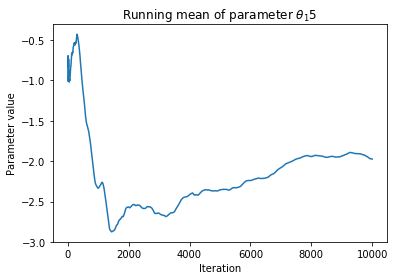

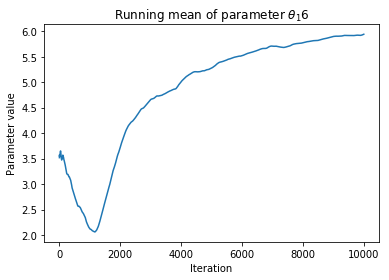

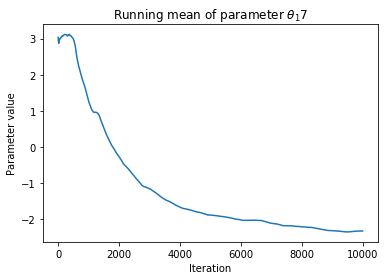

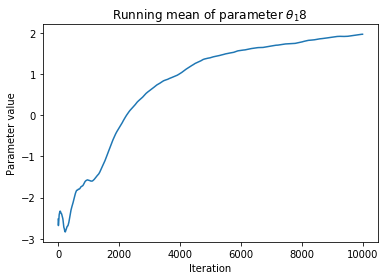

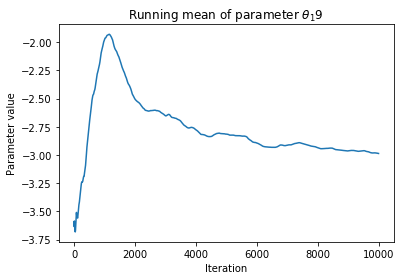

In [9]:
## Plot running means of simulated Markov chain

for i in range(model.num_params()):
    chain = sampler.chain.get_theta(i)
    chain_mean = torch.empty(len(chain))
    chain_mean[0] = chain[0]
    for j in range(1, len(chain)):
        chain_mean[j] = (chain[j]+j*chain_mean[j-1])/(j+1)
        
    plt.figure()
    sns.lineplot(range(len(chain)), chain_mean)
    plt.xlabel('Iteration')
    plt.ylabel('Parameter value')
    plt.title(r'Running mean of parameter $\theta_{}$'.format(i+1))

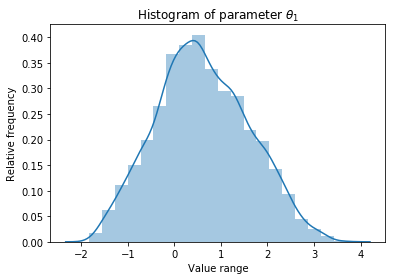

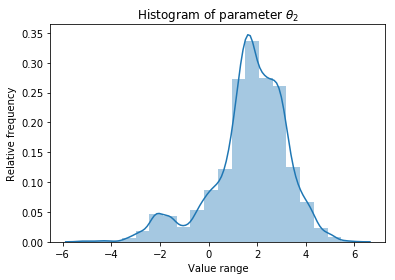

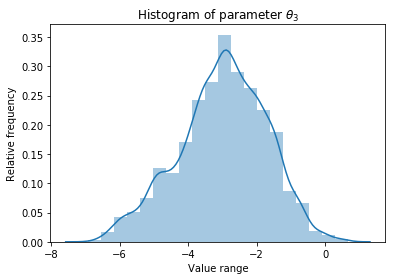

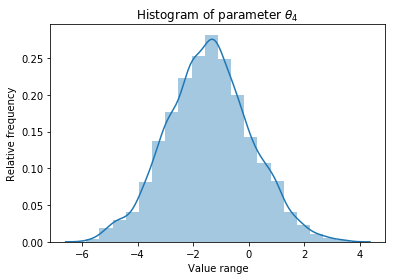

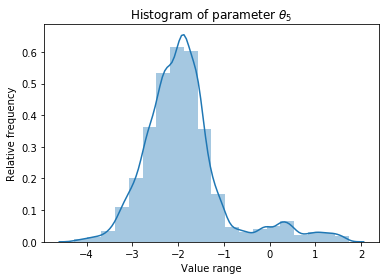

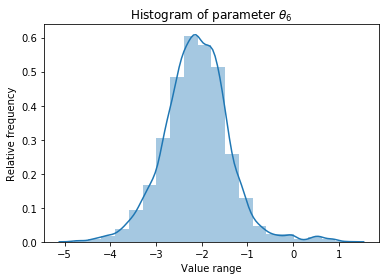

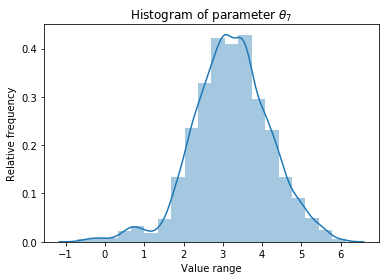

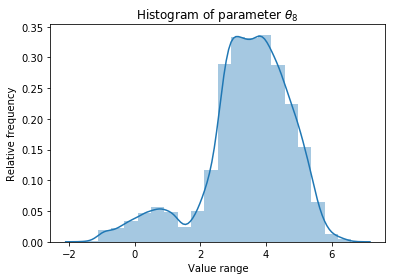

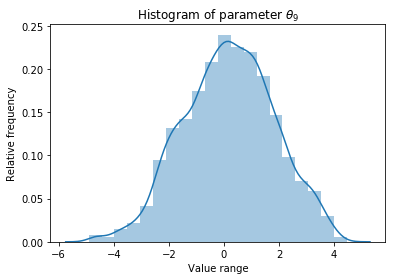

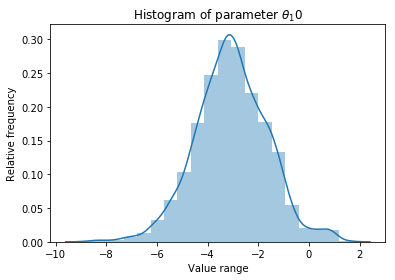

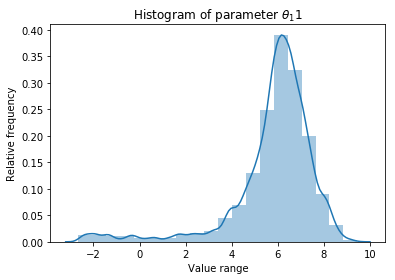

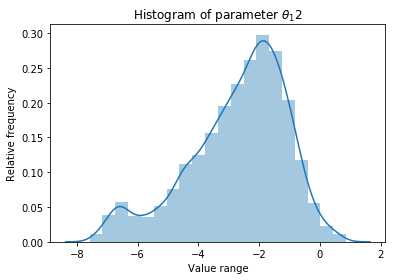

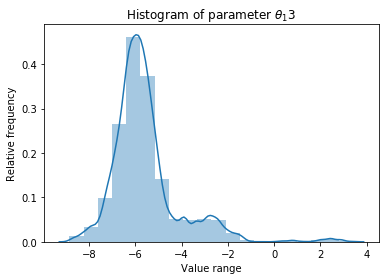

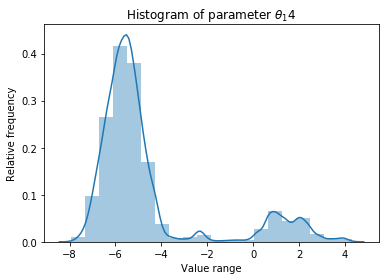

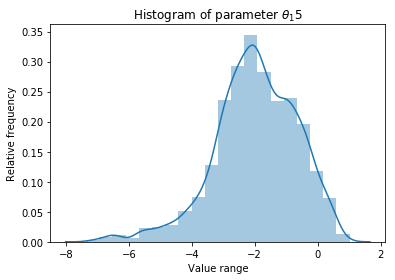

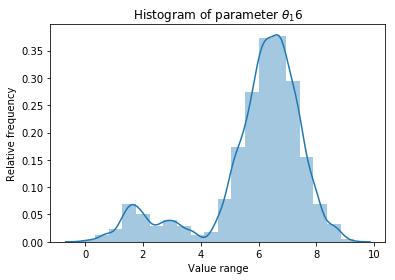

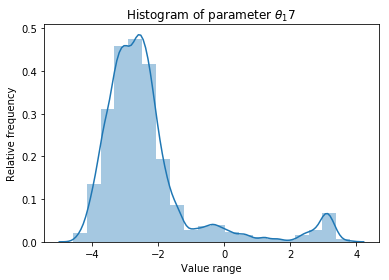

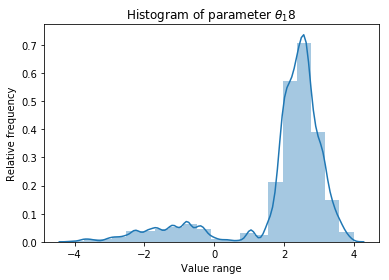

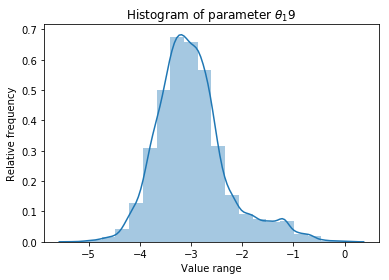

In [10]:
## Plot histograms of simulated Markov chain

for i in range(model.num_params()):
    plt.figure()
    sns.distplot(sampler.chain.get_theta(i), bins=20, norm_hist=True)
    plt.xlabel('Value range')
    plt.ylabel('Relative frequency')
    plt.title(r'Histogram of parameter $\theta_{}$'.format(i+1))